In [1]:

%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
from src.utils import get_wandb_summaries
import numpy as np
from src.utils import download_table
from src.data.utils import get_dask_df
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve
import itertools


In [109]:
from src.utils import download_table as download_wandb_table

In [108]:
RUNS = {
    "Same User":"2psz8fbu", #??
    "Autoencoder":"36mkbh97", 
    "Daily Features":"2i37p2nw",
    "No Pretraining":"2911eip8"
}

In [109]:
all_predictions = {}
for k,v in RUNS.items():
    all_predictions[k] = download_table(v,"test_predictions")

In [116]:
def bootstrapped_curve(pred,true,n_iterations=1000, return_stats = False, label=None,ax=None,
    curve_gen = roc_curve, ci=True, append_score_to_label=False, **kwargs):
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    if not ax:
        fig, ax = plt.subplots()
    
    n = len(pred)
    for i in range(n_iterations):
        inds = np.random.choice(np.arange(n), size=n, replace=True, p=None)
        fpr, tpr, _thresholds = curve_gen(true[inds],pred[inds])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        # interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
   

    mean_tpr = np.mean(tprs, axis=0)
    # mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    if append_score_to_label:
        label = f"{label} ({round(mean_auc,3)} AUC)"
    ax.plot(
        mean_fpr,
        mean_tpr,
        alpha=0.8,
        label=label,
        **kwargs,
    )
    if ci:
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + 2 * std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - 2 * std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            alpha=0.2,
            **kwargs
        )
    if return_stats:
        return mean_auc
    

def bootstrapped_roc_curve(pred,true,**kwargs):
    return bootstrapped_curve(pred,true,curve_gen = roc_curve, **kwargs)

def bootstrapped_pr_curve(pred,true, **kwargs):
    return bootstrapped_curve(pred,true, curve_gen = precision_recall_curve, **kwargs)




In [103]:
    
def plot_curves(runs,figsize=(7,4),legend_args={},roc=True,pr=True):   
    fig = plt.figure(figsize=figsize)
    if roc and pr:
        ax0 = plt.subplot(1, 2, 1,aspect="equal")
        ax1 = plt.subplot(1, 2, 2,aspect="equal")

    palette = itertools.cycle(sns.color_palette())
    predictions = {}
    for k,v in runs.items():
        predictions[k] = download_table(v,"test_predictions")
        
    for name,df in predictions.items():
        color=next(palette)
        
        bootstrapped_roc_curve(df["pred"],df["label"],label=name,ax=ax0,
            color=color,n_iterations=100)
        ax0.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)
        ax0.set(
            xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title="Receiver Operating\nCharacteristic (± 2 std)",
            xlabel="False Positive Rate",
            ylabel="True Positive Rate"
        )

        bootstrapped_pr_curve(df["pred"],df["label"],label=name,ax=ax1,
            color=color,n_iterations=100)
        
        ax1.set(
            xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title="Precision Recall (± 2 std)",
            xlabel="Recall",
            ylabel="Precision"
        )

    handles, labels = ax0.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(.5, -0.1), loc='lower center', ncol=4, **legend_args)
    plt.tight_layout()
    return fig

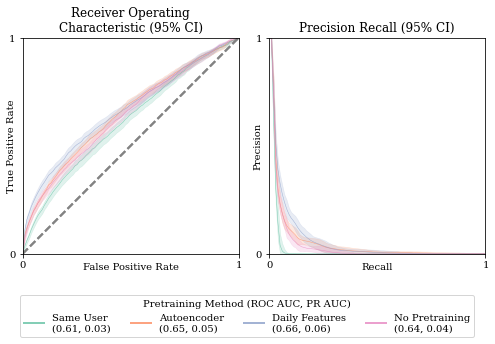

In [121]:
N_BOOTSTRAPS=10
with plt.style.context('/homes/gws/mikeam/seattleflustudy/src/visualization/stylesheets/paper.mplstyle'):
    fig = plt.figure(figsize=(7,4))
    ax0 = plt.subplot(1, 2, 1,aspect="equal")
    ax1 = plt.subplot(1, 2, 2,aspect="equal")

    roc_aucs = []
    pr_aucs = []

    palette = itertools.cycle(sns.color_palette("Set2"))

    for name,df in all_predictions.items():
        color=next(palette)
        
        roc_auc = bootstrapped_roc_curve(df["pred"],df["label"],label=name,ax=ax0,
            color=color,n_iterations=N_BOOTSTRAPS, linewidth=0.5, append_score_to_label=False,
            return_stats=True)
        roc_aucs.append(roc_auc)

        ax0.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)
        ax0.set(
            xlim=[-0, 1],
            ylim=[-0, 1],
            yticks=[0,1],
            xticks=[0,1],
            title="Receiver Operating\nCharacteristic (95% CI)",
            xlabel="False Positive Rate",
            ylabel="True Positive Rate"
        )
        ax0.set_ylabel("True Positive Rate", labelpad=-7.0)
        ax0.set_xlabel("False Positive Rate", labelpad=-7.0)

        pr_auc = bootstrapped_pr_curve(df["pred"],df["label"],label=name,ax=ax1,
            color=color,n_iterations=N_BOOTSTRAPS,linewidth=0.5, append_score_to_label=True,
            return_stats=True)
        pr_aucs.append(pr_auc)
    
    ax1.set(
        xlim=[-0, 1],
        ylim=[-0, 1],
        # xlim=[-0.05, 1.05],
        # ylim=[-0.05, 1.05],
        title="Precision Recall (95% CI)",
        # yscale="log",
        xlabel="Recall",
        ylabel="Precision",
        yticks=[0,1],
        xticks=[0,1],
        aspect="equal"
    )
    ax1.set_ylabel("Precision", labelpad=-7.0)
    ax1.set_xlabel("Recall", labelpad=-7.0)


    handles, labels = ax0.get_legend_handles_labels()
    
    new_labels = []
    for name, roc_auc, pr_auc in zip(labels,roc_aucs,pr_aucs):
        new_labels.append(f"{name}\n({roc_auc:.2f}, {pr_auc:.2f})")

    lgnd = fig.legend(handles, new_labels, bbox_to_anchor=(.5, -0.2), loc='lower center', ncol=4, title="Pretraining Method (ROC AUC, PR AUC)")
    for legobj in lgnd.get_lines():
        legobj.set_linewidth(2.0)

    plt.tight_layout()
plt.savefig("reports/kdd2022/pretraining-results.pdf", bbox_inches="tight")


In [115]:
pr_aucs

[None, None, None, None]

In [89]:
FLU_RUNS = {
    "Our Model":"z0nbehr0", 
    "XGBoost":"7r8nxjo5", 
    "CNN":"ko9zy18b"
}

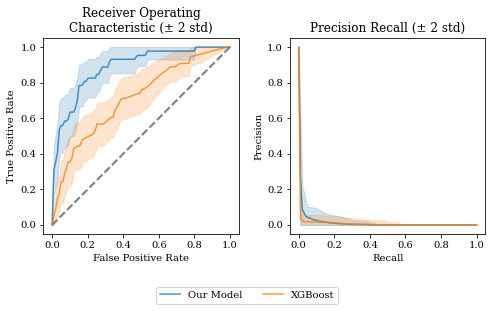

In [8]:
with plt.style.context('/homes/gws/mikeam/seattleflustudy/src/visualization/stylesheets/paper.mplstyle'):
    plot_curves(FLU_RUNS)

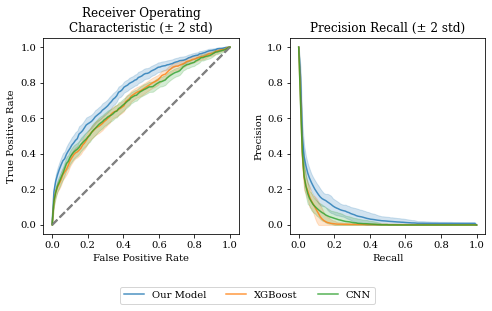

In [9]:
fatigue_runs = {
    "Our Model":"23qp4fss", 
    "XGBoost":"19h7xs81", 
    "CNN":"9kq7490z"
}
with plt.style.context('/homes/gws/mikeam/seattleflustudy/src/visualization/stylesheets/paper.mplstyle'):
    plot_curves(fatigue_runs)

In [10]:
flu_predictions = {}
for k,v in FLU_RUNS.items():
    flu_predictions[k] = download_table(v,"test_predictions")

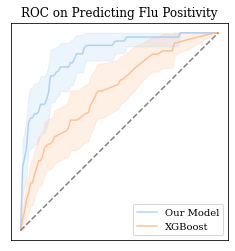

In [11]:
with plt.style.context('/homes/gws/mikeam/seattleflustudy/src/visualization/stylesheets/paper.mplstyle'):
    ax0 = plt.subplot(1, 1, 1,aspect="equal")
    palette = itertools.cycle(sns.color_palette("pastel"))
    for name,df in flu_predictions.items():
        color=next(palette)
        bootstrapped_roc_curve(df["pred"],df["label"],label=name,n_iterations=100,color=color, ax=ax0)
    ax0.set_yticklabels([])
    ax0.set_xticklabels([])
    ax0.set_xticks([])
    ax0.set_yticks([])
    plt.plot([0,1],[0,1], linestyle = "--", color="grey")
    plt.title("ROC on Predicting Flu Positivity")
    plt.legend()
plt.savefig("reports/kdd2022/teaser_roc_with_ci.svg")


In [1]:

%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
from src.utils import get_wandb_summaries
import numpy as np
from src.utils import download_table
from src.data.utils import get_dask_df
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve
import itertools

FLU_SYMPT_RUNS = {
    "Our Model":"289402rh", 
    "XGBoost":"1x254xwv", 
    "CNN":"1apcb94k",
    "CNN-Transformer":"2911eip8"
}

In [3]:
## Compute ammount of missing data per day:
all_activity = get_dask_df("processed_fitbit_minute_level_activity").compute()
missing_counts = all_activity.groupby(["participant_id","date"])["missing_heartrate"].sum()

In [4]:
missing_counts = missing_counts.reset_index()
missing_counts["date"] = missing_counts["date"].dt.date

In [5]:
flu_sympt_predictions = {}
for k,v in FLU_SYMPT_RUNS.items():
    df = download_table(v,"test_predictions")
    df["date"] = pd.to_datetime(df["date"]).dt.date
    flu_sympt_predictions[k] = df.merge(missing_counts,how="inner",on=["participant_id","date"])


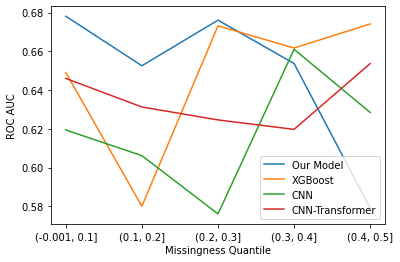

In [26]:
bins = np.linspace(0,0.5,6)
for k,df in flu_sympt_predictions.items():
    df["missing_perc"] = df["missing_heartrate"] / (24*60)
    df["bin"] =  pd.cut(df["missing_perc"], bins=bins, include_lowest=True).cat.remove_unused_categories()

    rocs = df.groupby("bin").apply(lambda x: safe_roc(x["label"],x["pred"]))
    plt.plot(rocs.index.astype(str), rocs,label=k)
    plt.legend()
    plt.xlabel("Missingness Quantile")
    plt.ylabel("ROC AUC")

In [70]:
FLU_RUNS = {
    "XGBoost":"7r8nxjo5", 
    "Our Model":"z0nbehr0", 
}
flu_pos = {}
for k,v in FLU_RUNS.items():
    if v == "z0nbehr0":
        version = "v0"
    else:
        version="latest"
    df =  download_table(v,"test_predictions",v=version)
    df["date"] = pd.to_datetime(df["date"]).dt.date
    flu_pos[k] = df.merge(missing_counts,how="inner",on=["participant_id","date"])


Our Model bin
(-0.001, 0.1]    0.908051
(0.1, 0.2]       0.804710
(0.2, 0.3]       0.968389
dtype: float64
XGBoost bin
(-0.001, 0.1]    0.698980
(0.1, 0.2]       0.801809
(0.2, 0.3]       0.533565
dtype: float64


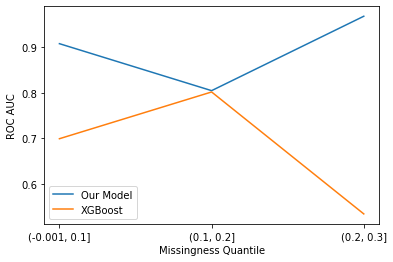

In [31]:
def safe_roc(x,y):
    try:
        return roc_auc_score(x,y)
    except ValueError:
        return np.nan

bins = np.linspace(0,0.3,4)
for k,df in flu_pos.items():
    df["missing_perc"] = df["missing_heartrate"] / (24*60)
    df["bin"] =  pd.cut(df["missing_perc"], bins=bins, include_lowest=True).cat.remove_unused_categories()

    rocs = df.groupby("bin").apply(lambda x: safe_roc(x["label"],x["pred"]))
    print(k,rocs)
    plt.plot(rocs.index.astype(str), rocs,label=k)
    plt.xlabel("Missingness Quantile")
    plt.ylabel("ROC AUC")
plt.legend()

In [71]:
def safe_pr_auc(true,pred):
    precision, recall, _thresholds = precision_recall_curve(true,pred)
    mean_auc = auc(recall,precision)
    return mean_auc

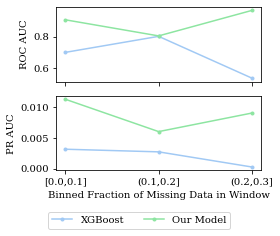

In [94]:
with plt.style.context('/homes/gws/mikeam/seattleflustudy/src/visualization/stylesheets/paper.mplstyle'):
    fig = plt.figure(figsize=(4,3))
    ax0 = plt.subplot(2, 1, 1)
    ax1 = plt.subplot(2, 1, 2, sharex=ax0)
    palette = itertools.cycle(sns.color_palette("pastel"))
    bins = np.linspace(0,0.3,4)

    i = 0
    for k,df in flu_pos.items():
        
        color = next(palette)
        if i == 1:
            # Keep consistent color scheme
            color = next(palette)

        df["missing_perc"] = df["missing_heartrate"] / (24*60)
        df["bin"] =  pd.cut(df["missing_perc"], bins=bins, include_lowest=True).cat.remove_unused_categories()

        roc_aucs = df.groupby("bin").apply(lambda x: safe_roc(x["label"],x["pred"]))

        ax0.plot(roc_aucs.index.astype(str), roc_aucs,label=k,color=color,marker = ".")

        pr_aucs = df.groupby("bin").apply(lambda x: safe_pr_auc(x["label"].values,x["pred"].values))
        ax1.plot(pr_aucs.index.astype(str), pr_aucs, color=color, marker = ".")
        i+=1


    ax0.set_xlabel("")
    ax0.set_ylabel("ROC AUC")
    
    plt.setp(ax0.get_xticklabels(), visible=False)


    ax1.set_xlabel("Binned Fraction of Missing Data in Window")
    ax1.set_ylabel("PR AUC")

    ax1_labels = ["[0.0,0.1]","(0.1,0.2]","(0.2,0.3]"]
    ax1_ticks = ax1.get_xticks()

    ax1.set_xticks(ax1_ticks, ax1_labels)

    fig.tight_layout()
    fig.legend(loc='lower center', ncol=2,  bbox_to_anchor=(.5, -0.1))

plt.savefig("reports/kdd2022/binned_missingness.pdf", bbox_inches="tight")

In [99]:
(df["missing_perc"] < 0.3).sum() / len(df["missing_perc"])

0.8979423224100744